# Infer ***lysosome*** -  4️⃣

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component ***lysosome***  in order to understand interactome 



Dependencies:
The ***lysosome***  inference rely on the ***cytosol*** mask.


## preamble

1. imports
2. setup
3. get cytosol mask
4. infer lysosomes
    * pre-processing
    * core processing
    * post processing
5. export lysosomes


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.vessel import filament_2d_wrapper
from skimage.measure import label

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)
from infer_subc_2d.core.img import *
from infer_subc_2d.organelles import fixed_infer_cellmask_fromaggr_MCZ, fixed_infer_nuclei, infer_cytoplasm

%load_ext autoreload
%autoreload 2




## SETUP


CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.


In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK



In [5]:

# nuclei_fname = "/Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"

cytoplasm_mask = import_inferred_organelle("cytosol", meta_dict, out_data_path)

if cytoplasm_mask is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    cellmask = fixed_infer_cellmask_fromaggr_MCZ(img_data, nuclei)
    nucleus_obj =  apply_mask(nuclei, cellmask) 
    cytoplasm_mask =  infer_cytoplasm(cellmask, nucleus_obj, erode_nuclei=False) 
    out_file_n = export_inferred_organelle(cytoplasm_mask, "cytosol", meta_dict, out_data_path)
    print(f"calculated cytosol mask. wrote {out_file_n}")
else:
    print(f"loaded cytosol mask from {out_data_path}")


loaded cytosol mask from /Users/ahenrie/Projects/Imaging/data/out


---------------------

## infer ***lysosome***

## summary of steps (Workflow #1 & #2)

INPUT
- channel  2
- cytosol mask

PRE-PROCESSING
-  smooth / remove noise

CORE-PROCESSING
- enhance two classes of "spots"
-  segment objects

POST-PROCESSING
  - filter objects

OUTPUT
- object ***lysosome*** 


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter LAMP1 [workflow](https://www.allencell.org/cell-observations/category/lamp1).  Examples sourced from: [Notebook](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/lookup_table_demo/playground_lamp1.ipynb) and [script](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/aicssegmentation/structure_wrapper/seg_lamp1.py)



## INPUT prototype

In [6]:

###################
# INPUT
###################
raw_lyso = select_channel_from_raw(img_data, LYSO_CH)


## PRE-PROCESSING prototype


In [7]:
###################
# PRE_PROCESSING
###################
med_filter_size = 3   
gaussian_smoothing_sigma = 1.34

# # Linear-ish smoothing
# lysosome = min_max_intensity_normalization( raw_lyso)
# structure_img_median = median_filter_slice_by_slice( lysosome, size=med_filter_size  )
# structure_img_smooth = image_smoothing_gaussian_slice_by_slice(  structure_img_median,
#                                                                                             sigma=gaussian_smoothing_sigma )

struct_img =  scale_and_smooth(raw_lyso,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)

## CORE PROCESSING prototype

In [8]:
###################
# CORE_PROCESSING
###################
## PARAMETERS for this step ##
s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
################################
bw_spot = dot_2d_slice_by_slice_wrapper(struct_img, s2_param)


################################
## PARAMETERS for this step ##
f2_param = [[1, 0.15]]
################################
bw_filament = filament_2d_wrapper(struct_img, f2_param)
bw = np.logical_or(bw_spot, bw_filament)


### POST-PROCESSING

> NOTE: we are using the 3D aicssegmentation functions which wrap `scipy.ndimage` functions with a single Z rather than the `scipy.ndimage` functions directly

In [9]:
###################
# POST_PROCESSING
###################

################################
## PARAMETERS for this step ##
fill_2d = True
fill_max_size = 25
hole_min = 0
################################
removed_holes = hole_filling_linear_size(bw, hole_min=0, hole_max=fill_max_size)

small_object_width = 3  
cleaned_img = size_filter_linear_size(removed_holes, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width, 
                                                         connectivity=1)

cleaned_img2 = fill_and_filter_linear_size(bw, hole_min=0, hole_max=fill_max_size, min_size= small_object_width)

#DEPRICATE masking until stat collection
# masked_img = apply_mask(cleaned_img, cytoplasm_mask)


## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()

viewer.add_image(cytoplasm_mask)    

<Image layer 'cytoplasm_mask' at 0x14b7da160>

In [11]:

viewer.add_image(
    removed_holes,
)


<Image layer 'removed_holes' at 0x10f7037c0>

In [12]:

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img,
)


<Image layer 'cleaned_img' at 0x16e2a6ac0>

## DEFINE `_infer_lyso` function

Based on the _prototyping_ above define the function to infer the lysosomes.  



In [13]:
##########################
#  infer_LYSOSOMES
##########################
def _infer_lyso(
                                in_img: np.ndarray,
                                median_sz: int,
                                gauss_sig: float,
                                dot_scale_1: float,
                                dot_cut_1: float,
                                dot_scale_2: float,
                                dot_cut_2: float,
                                dot_scale_3: float,
                                dot_cut_3: float,
                                filament_scale : float,
                                filament_cut : float,
                                min_hole_w: int,
                                max_hole_w: int,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    min_hole_w: 
        hole filling min for nuclei post-processing
    max_hole_w: 
        hole filling cutoff for nuclei post-processing
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    lyso_object
        mask defined extent of lysosome object

    """
    lyso_ch = LYSO_CH
    ###################
    # EXTRACT
    ###################    
    lyso = select_channel_from_raw(in_img, lyso_ch)

     ###################
    # PRE_PROCESSING
    ###################    
    # lyso = min_max_intensity_normalization(lyso)
    # lyso = median_filter_slice_by_slice(lyso, size=median_sz)
    # lyso = image_smoothing_gaussian_slice_by_slice(lyso, sigma=gauss_sig)
    lyso =  scale_and_smooth(lyso,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)
   ###################
    # CORE_PROCESSING
    ###################
    # s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
    s2_param = [    
                [dot_scale_1, dot_cut_1],
                [dot_scale_2, dot_cut_2],
                [dot_scale_3, dot_cut_3]
                ]
    bw_spot = dot_2d_slice_by_slice_wrapper(lyso, s2_param)

    f2_param = [[filament_scale, filament_cut]]
    # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
    bw_filament = filament_2d_wrapper(lyso, f2_param)

    bw = np.logical_or(bw_spot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################
    # struct_obj = hole_filling_linear_size(bw, hole_min=min_hole_w, hole_max=max_hole_w)
    # struct_obj = size_filter_linear_size(struct_obj, # wrapper to remove_small_objects which can do slice by slice
    #                                                         min_size= small_obj_w, 
    #                                                         connectivity=1)
    struct_obj = fill_and_filter_linear_size(bw, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)

    return struct_obj

## DEFINE `_fixed_infer_lyso` function


In [14]:


##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_lyso(in_img: np.ndarray  ) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input with *fixed parameters*
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    lyso_object
        mask defined extent of NU
    """
    median_sz = 4
    gauss_sig = 1.34
    dot_scale_1 = 5
    dot_cut_1 = 0.09
    dot_scale_2 = 2.5
    dot_cut_2 = 0.07
    dot_scale_3 = 1
    dot_cut_3 = 0.01
    filament_scale = 1
    filament_cut = 0.15
    min_hole_w = 0
    max_hole_w = 25
    small_obj_w = 3

    return _infer_lyso(  
        in_img,
        median_sz,
        gauss_sig,
        dot_cut_1,
        dot_scale_1,
        dot_cut_2,
        dot_scale_2,
        dot_cut_3,
        dot_scale_3,
        filament_scale,
        filament_cut ,
        min_hole_w,
        max_hole_w,
        small_obj_w
        )


------------------

# TEST `_infer_lyso` function defined above

In [15]:

_lyso_object =  _fixed_infer_lyso(img_data) 



In [16]:
from infer_subc_2d.organelles.lysosome import fixed_infer_lyso

lyso_object =  fixed_infer_lyso(img_data) 



## Visualize  2


In [17]:

viewer.add_image(
    _lyso_object,
    scale=scale
)
viewer.add_labels(
    label(lyso_object),
    scale=scale
)
viewer.add_image(
    lyso_object,
    scale=scale
)

<Image layer 'lyso_object' at 0x171dbe1f0>

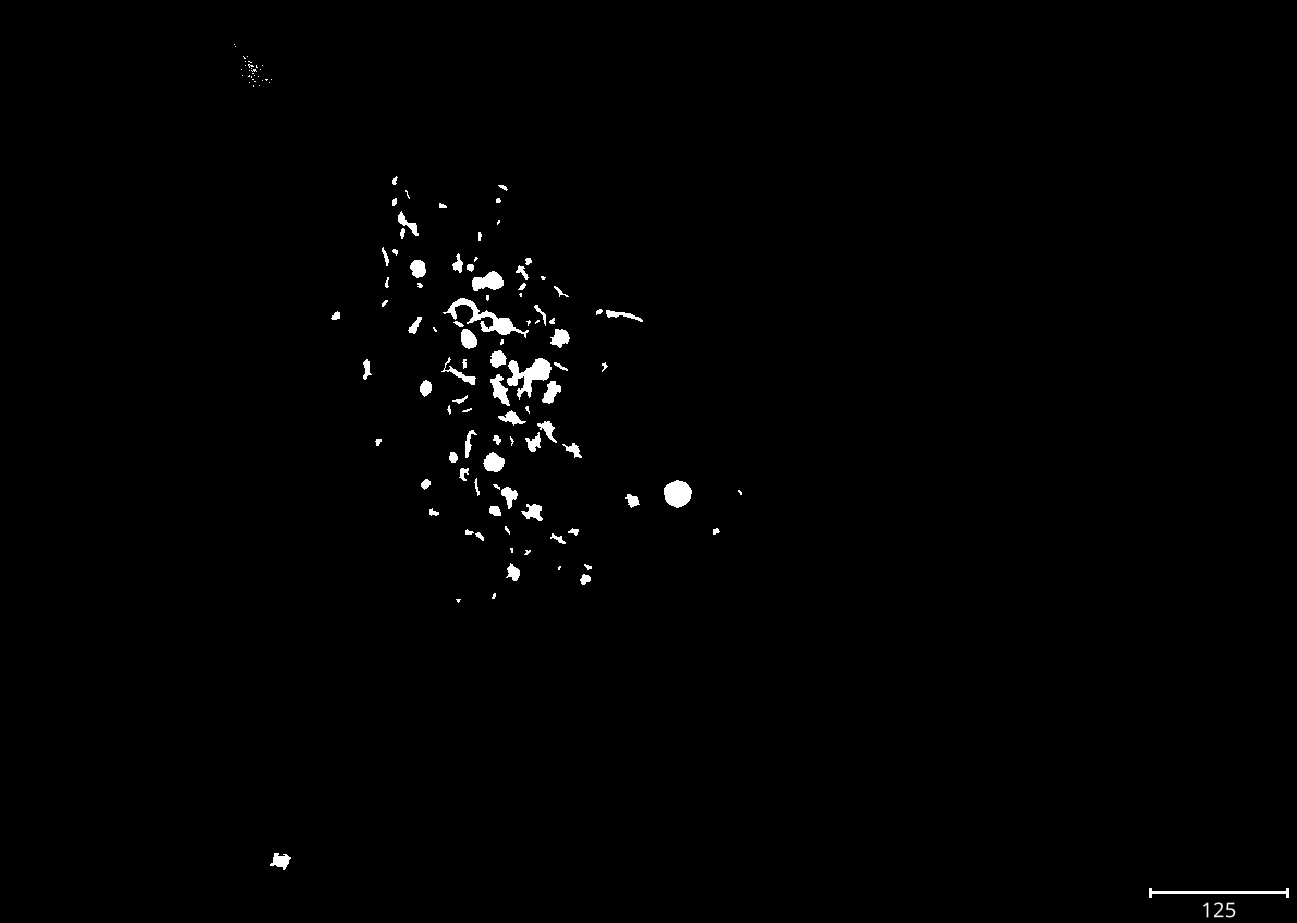

In [18]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [19]:
viewer.close()

-----------------
Write the `infer_lyso` spec to the widget json 

-------------
## SUMMARY

The above details how the lysosome object is inferred.  

### NEXT: INFER MITOCHONDRIA

proceed to [05_infer_mito.ipynb](./05_infer_mito.ipynb)
